In [ ]:
# default_exp tree_likelihood

In [1]:
from multiinstance.ward_clustering import WardClustering

In [2]:
from multiinstance.utils import *
from multiinstance.data.syntheticData import buildDataset,getBag

# import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# export
from autograd import grad,hessian
from autograd.scipy import  stats as agss
import autograd.numpy as np

import scipy.stats as ss

from tqdm.notebook import tqdm

In [4]:
from multiinstance.data.realData import buildDataset as buildReal

In [5]:
from glob import glob

In [6]:
# export

class LikelihoodMethod:
    def __init__(self,ds,clusterAssignments, alphaHatMat,lr=0.01,rowLambda=1.0):
        self.ds = ds
        self.clusterAssignments = clusterAssignments.astype(int)
        self.alphaHatMat = alphaHatMat
        self.leafMeans = np.mean(self.alphaHatMat[0],axis=1)
        self.initClusterVariances()
        self.lr = lr
        self.meanHistory = []
        self.varianceHistory = []
        self.MAEs = []
        self.NLLs = []
        self.rowLambda = rowLambda
        
    def initClusterVariances(self):
            self.clusterVariances = []
            # Coordinate tuple in clusterAssignment -> index withing cluster variances
            self.loc2Idx = {}
            for rowNum in range(self.clusterAssignments.shape[0]):
                levelClusters = np.unique(self.clusterAssignments[rowNum])
                for cluster in levelClusters:
                    self.loc2Idx[(rowNum,cluster)] = len(self.clusterVariances)
                    alphaHats= self.alphaHatMat[rowNum, cluster]
                    _,v = ss.norm.fit(alphaHats)
                    self.clusterVariances.append(v)
                    
            self.clusterVariances = np.array(self.clusterVariances)
                    
    def logLikelihood(self,alphaHats, mu, sigma):
        LL = np.sum(agss.norm.logpdf(alphaHats, mu, sigma))
        LL = LL * (1 / len(alphaHats))
        return LL

    def treeNegativeLogLikelihood(self):
        def getLevelClusters(rowNum):
            clusterLabels = np.unique(self.clusterAssignments[rowNum])
            clusters = {c : np.where(self.clusterAssignments[rowNum] == c)[0] for c in clusterLabels}
            return clusters
        
        def getClusterMean(leafMeans, clusterMembers):
            leafSizes= np.array([self.ds.numU[i] for i in clusterMembers])
            alphaTilde = np.dot(leafMeans[clusterMembers], leafSizes) / np.sum(leafSizes)
            return alphaTilde
            
        def NLL(leafMeans, clusterVars):
            ll = 0
            for rowNum in range(self.clusterAssignments.shape[0]):
                clusters = getLevelClusters(rowNum)
                for clusterIdx, clusterMembers in clusters.items():
                    clusterMean = getClusterMean(leafMeans,clusterMembers)
                    varIdx = self.loc2Idx[(rowNum, clusterIdx)]
                    clusterVar = clusterVars[varIdx]
                    alphaHats = self.alphaHatMat[rowNum, clusterIdx]
                    ll = ll + self.rowLambda**rowNum * self.logLikelihood(alphaHats, clusterMean, clusterVar)
            return -1 * ll
        return NLL

    def run(self, n_iters):
        gradNLL_mu = grad(self.treeNegativeLogLikelihood(), 0)
        gradNLL_sigma = grad(self.treeNegativeLogLikelihood(), 1)
        hessianNLL_mu = hessian(self.treeNegativeLogLikelihood(), 0)
        hessianNLL_sigma = hessian(self.treeNegativeLogLikelihood(), 1)
        self.log()
        means = self.leafMeans
        var = self.clusterVariances
        for iteration in tqdm(range(n_iters)):
            if not n_iters % 500:
                self.lr *= .95
            deltaMu = np.linalg.inv(hessianNLL_mu(means,
                                                  var)) @ gradNLL_mu(means,
                                                                     var)
            deltaSigma = np.linalg.inv(hessianNLL_sigma(mean,
                                                        var)) @ gradNLL_sigma(means,
                                                                             var)
            means = means - self.lr * deltaMu
            var = var - self.lr * deltaSigma
            assert (self.clusterVariances > 0).all()
            self.log()

    def log(self):
        self.MAEs.append(np.mean(np.abs(dsi.trueAlphas.flatten() - self.leafMeans)))
        nllfunc = self.treeNegativeLogLikelihood()
        self.NLLs.append(nllfunc(self.leafMeans, self.clusterVariances))
        self.meanHistory.append(self.leafMeans)
        self.varianceHistory.append(self.clusterVariances)

In [7]:
def plotDistrTree(trueAlphas, alphaHatMat, meanHistory, scaleHistory,loc2Index,clusterAssignments, numU):
    rows,cols = list(zip(*list(method.loc2Idx.keys())))
    Nrows = np.max(rows) + 1
    Ncols = np.max(cols) + 1
    fig,ax = plt.subplots(nrows=Nrows,ncols=Ncols, figsize=(5 * Nrows, 5*Ncols))
    for row in range(clusterAssignments.shape[0]):
        clusters = np.unique(clusterAssignments[row])
        for c in clusters:
            scale = scaleHistory[-1][loc2Index[(row,c)]]
            scale0 = scaleHistory[0][loc2Index[(row,c)]]
            children = np.where(clusterAssignments[row] == c)[0]
            childMeans = meanHistory[-1][children]
            childMeans0 = meanHistory[0][children]
            childN = numU[children]
            mu = np.dot(childMeans, childN) / childN.sum()
            mu0 = np.dot(childMeans0, childN) / childN.sum()
            alpha = np.dot(trueAlphas[children], childN)/ childN.sum()
            ax[row,c].plot(np.arange(0,1,.01),
                           ss.norm.pdf(np.arange(0,1,.01),loc=mu,scale=scale),color="green")
            ax[row,c].plot(np.arange(0,1,.01),
                           ss.norm.pdf(np.arange(0,1,.01),loc=mu0,scale=scale0),color="red",alpha=.5)
            ax[row,c].hist(alphaHatMat[row,c],density=True,color="blue")
            ax[row,c].vlines(alpha, 0,1,color="red")
    plt.show()
    return fig

In [8]:
from sklearn.metrics import roc_auc_score
def posteriorCorrection(tau, alpha, S0S1):
    post =  alpha * S0S1 * (tau / (1 - tau))
    post[np.isinf(post)] = 1
    return post

def correctedAUC(ds,bagAlphaHats,):
    _, tauArrays = list(zip(*[getTransformScores(ds,i) for i in range(ds.N)]))
    S0_S1 = ds.numU/ds.numP
    posteriors = [posteriorCorrection(tau,alphaHat, s0s1) for tau,alphaHat,s0s1 in zip(tauArrays,
                                                                                       bagAlphaHats,
                                                                                       S0_S1)]
    posteriorVals = np.concatenate(posteriors)
    hiddenLabels = np.concatenate([ds.hiddenLabels[i][:ds.numU[i]] for i in range(ds.N)])
    return roc_auc_score(hiddenLabels, posteriorVals)

In [10]:
dsi = buildDataset(1,alphaDistr=lambda: np.random.choice([.2]),
                  nP=100,nU=200,posMean=5,negMean=1,cov=1)
ds2 = buildDataset(1,alphaDistr=lambda: np.random.choice([.8]),
                  nP=100,nU=200,posMean=5,negMean=1,cov=1)
dsi.merge(ds2)
dsi = addTransformScores(dsi)
dsi = addGlobalEsts(dsi)
dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=25)

In [11]:
ward = WardClustering(dsi,numbootstraps=dsi.alphaHats.shape[-1],randomPairing=True)
ward.cluster()

In [35]:
ward.alphaHatMat

array([[[0.08641639, 0.15095384, 0.13152865, 0.09405464, 0.14020003,
         0.12016486, 0.12376165, 0.12270778, 0.09287919, 0.16481756,
         0.07764378, 0.075278  , 0.14305523, 0.07468419, 0.21267532,
         0.09297498, 0.12746596, 0.09761137, 0.05538139, 0.11598325,
         0.08819287, 0.0939725 , 0.14431173, 0.13881007, 0.10801165],
        [0.81210852, 0.55421925, 0.39001101, 0.41709566, 0.53271419,
         0.77035958, 0.75888175, 0.74990326, 0.84940875, 0.80711275,
         0.58265519, 0.61104655, 0.70967036, 0.58734328, 0.23392665,
         0.82304853, 0.22314967, 0.72024512, 0.54445195, 0.76449329,
         0.30675051, 0.44375885, 0.79951644, 0.64805436, 0.803882  ]],

       [[0.52703178, 0.48530766, 0.51878262, 0.51963454, 0.51073098,
         0.52794206, 0.45243204, 0.53635669, 0.53132975, 0.51881599,
         0.44888628, 0.52276468, 0.48362917, 0.51549172, 0.51550496,
         0.51329803, 0.54439974, 0.43393654, 0.45948243, 0.50223702,
         0.45923832, 0.4739613

In [20]:
method = LikelihoodMethod(dsi,ward.clusterAssignment,
                          ward.alphaHatMat + np.random.normal(scale=0.00001,size=ward.alphaHatMat.shape),
                          lr=0.1,rowLambda=1.0)


In [26]:
method.run(100)

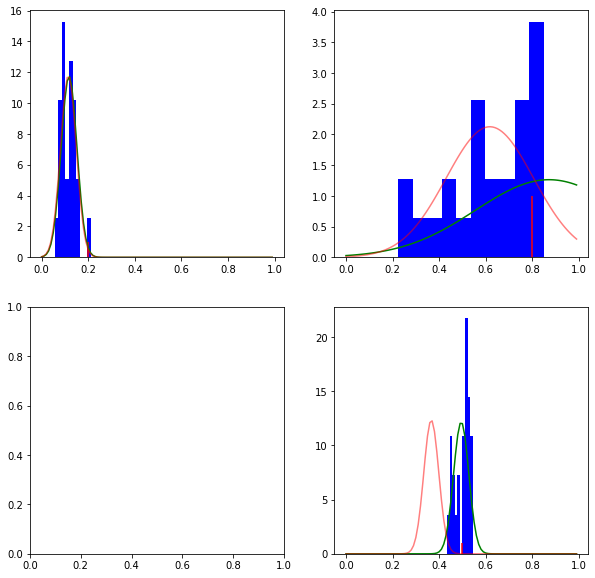

In [27]:
fig = plotDistrTree(dsi.trueAlphas.flatten(),method.alphaHatMat, method.meanHistory,
              method.varianceHistory, method.loc2Idx, method.clusterAssignments, dsi.numU)

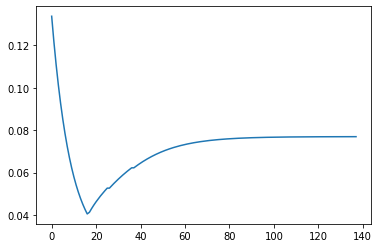

In [28]:
plt.plot(method.MAEs)

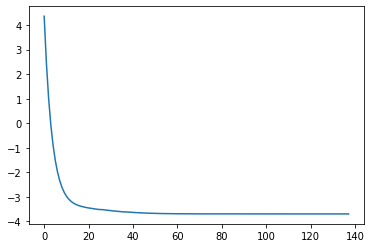

In [29]:
plt.plot(method.NLLs)

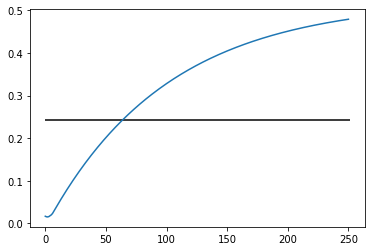

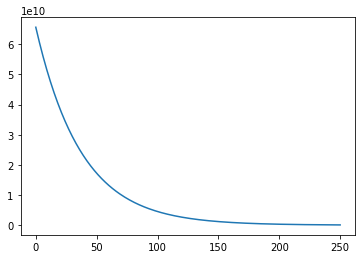

MAE
local: 0.017
likelihood: 0.479
global: 0.244
AUC
local: 0.982
likelihood: 0.830
global: 0.993


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


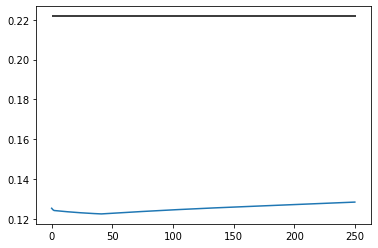

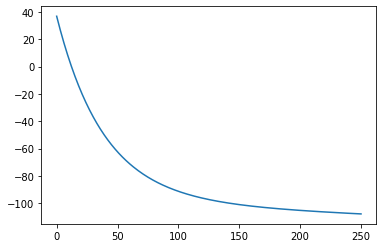

MAE
local: 0.071
likelihood: 0.304
global: 0.233
AUC
local: 0.939
likelihood: 0.862
global: 0.924


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


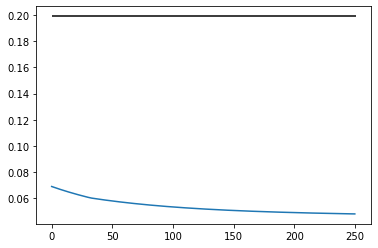

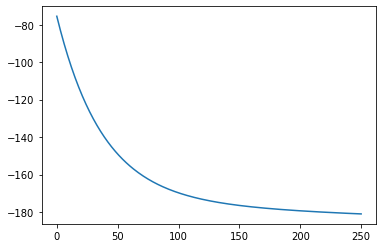

MAE
local: 0.070
likelihood: 0.219
global: 0.221
AUC
local: 0.953
likelihood: 0.902
global: 0.941


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


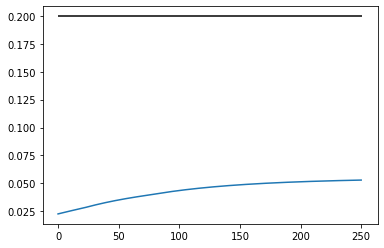

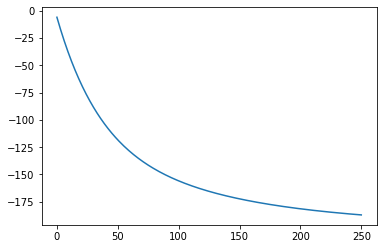

MAE
local: 0.058
likelihood: 0.177
global: 0.216
AUC
local: 0.963
likelihood: 0.924
global: 0.953


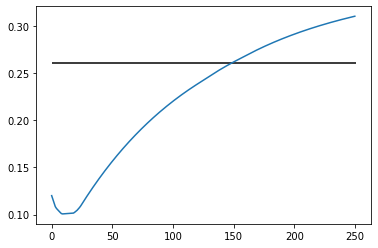

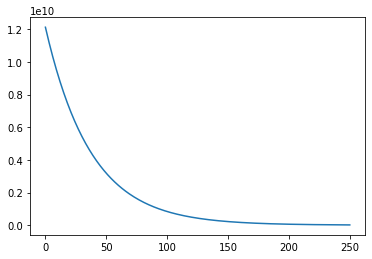

MAE
local: 0.071
likelihood: 0.204
global: 0.225
AUC
local: 0.954
likelihood: 0.857
global: 0.938


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


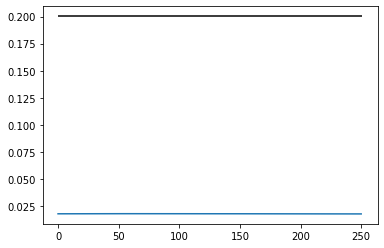

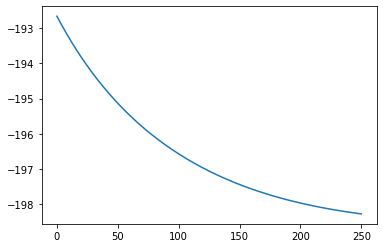

MAE
local: 0.062
likelihood: 0.173
global: 0.221
AUC
local: 0.959
likelihood: 0.879
global: 0.946


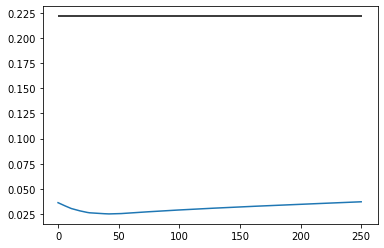

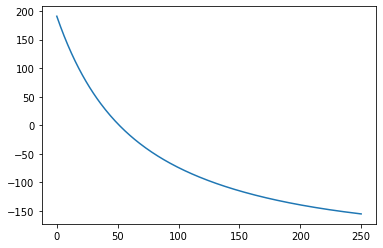

MAE
local: 0.058
likelihood: 0.153
global: 0.221
AUC
local: 0.963
likelihood: 0.893
global: 0.951


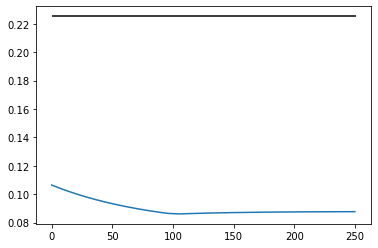

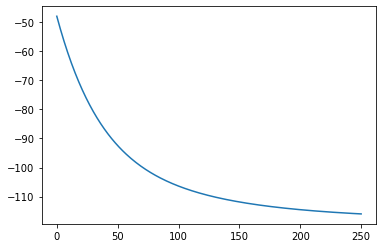

MAE
local: 0.064
likelihood: 0.145
global: 0.221
AUC
local: 0.952
likelihood: 0.892
global: 0.941


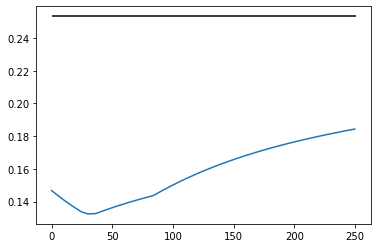

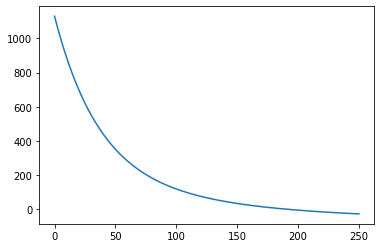

MAE
local: 0.073
likelihood: 0.150
global: 0.225
AUC
local: 0.937
likelihood: 0.878
global: 0.925


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


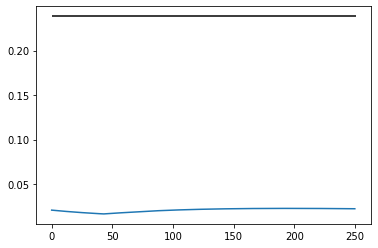

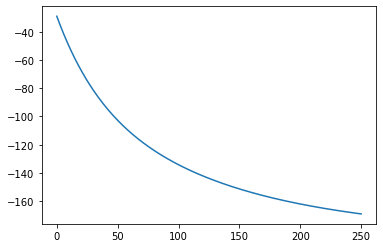

MAE
local: 0.068
likelihood: 0.137
global: 0.226
AUC
local: 0.942
likelihood: 0.890
global: 0.931


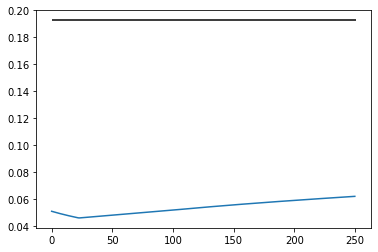

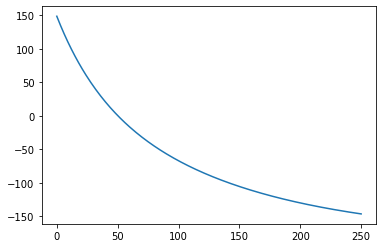

MAE
local: 0.067
likelihood: 0.130
global: 0.223
AUC
local: 0.946
likelihood: 0.898
global: 0.935


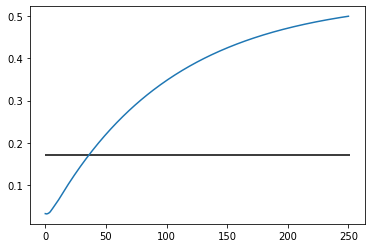

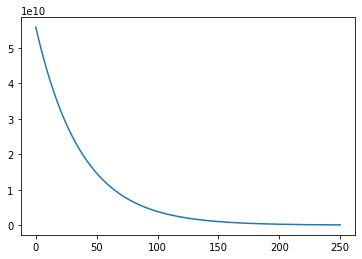

MAE
local: 0.064
likelihood: 0.161
global: 0.219
AUC
local: 0.948
likelihood: 0.890
global: 0.937


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


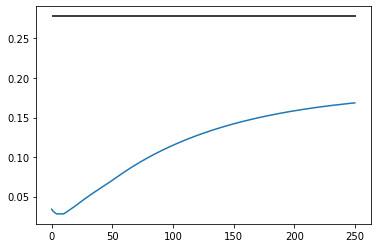

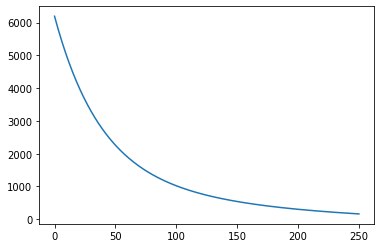

MAE
local: 0.062
likelihood: 0.161
global: 0.224
AUC
local: 0.952
likelihood: 0.898
global: 0.942


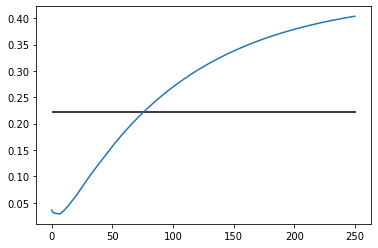

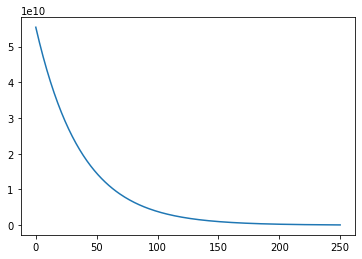

MAE
local: 0.060
likelihood: 0.179
global: 0.223
AUC
local: 0.953
likelihood: 0.884
global: 0.944


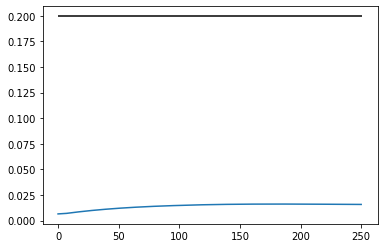

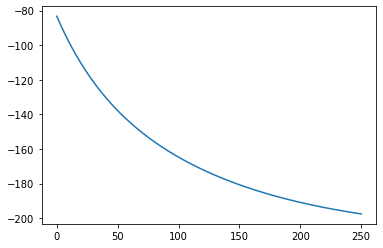

MAE
local: 0.056
likelihood: 0.168
global: 0.222
AUC
local: 0.956
likelihood: 0.892
global: 0.948


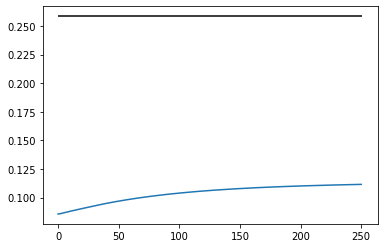

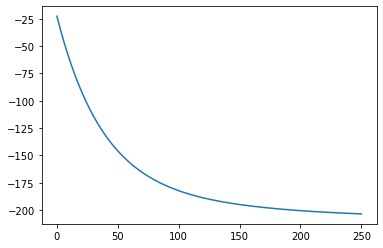

MAE
local: 0.058
likelihood: 0.164
global: 0.224
AUC
local: 0.957
likelihood: 0.897
global: 0.948


AssertionError: 

In [36]:
absErrs = {"local":[],
           "likelihood":[],
           "global": []}
aucVals = {
    "local":[],
    "likelihood":[],
    "global":[]
}
N = 0
for f in tqdm(glob("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/*.mat")):
    dsi = buildReal(f,16,
                    alphaDistr=lambda: np.random.uniform(.05,.95),
                    nPDistr=lambda: 1 + np.random.poisson(125),
                    nUDistr=lambda: 1 + np.random.poisson(175))
    dsi = addTransformScores(dsi)
    dsi = addGlobalEsts(dsi,reps=10)
    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,
                                               numbootstraps=100)
    globalMAE = np.mean(np.abs(dsi.trueAlphas.flatten() - dsi.globalAlphaHats.mean()))
    absErrs["global"].append(globalMAE * dsi.N)
    aucVals["local"].append(correctedAUC(dsi,dsi.alphaHats.mean(1)))
    aucVals["global"].append(correctedAUC(dsi,np.ones(dsi.N)*dsi.globalAlphaHats.mean()))
    wrd = WardClustering(dsi,numbootstraps=dsi.alphaHats.shape[1],randomPairing=True)
    wrd.cluster()
    mth = LikelihoodMethod(dsi,wrd.clusterAssignment,
                              wrd.alphaHatMat + np.random.normal(scale=0.00001,size=wrd.alphaHatMat.shape),
                              lr=0.01,rowLambda=1.0)
    mth.run(250)
    absErrs["local"].append(mth.MAEs[0] * dsi.N)
    absErrs["likelihood"].append(mth.MAEs[-1] * dsi.N)
    aucVals["likelihood"].append(correctedAUC(dsi, mth.leafMeans))
    maefig,ax = plt.subplots()
    
    ax.plot(mth.MAEs)
    
    ax.hlines(globalMAE,0,len(mth.MAEs),label="global")
    plt.show()
#     treeFig = plotDistrTree(dsi.trueAlphas.flatten(),
#                         mth.alphaHatMat,
#                         mth.meanHistory,
#                         mth.varianceHistory,
#                         mth.loc2Idx,
#                         mth.clusterAssignments,
#                         dsi.numU)
#     plt.show()
    fig,ax = plt.subplots()
    plt.plot(mth.NLLs)
    plt.show()
    N += dsi.N
    print("MAE")
    print("local: {:.3f}".format(np.sum(absErrs["local"])/N))
    print("likelihood: {:.3f}".format(np.sum(absErrs["likelihood"])/N))
    print("global: {:.3f}".format(np.sum(absErrs["global"])/N))
    print("AUC")
    print("local: {:.3f}".format(np.mean(aucVals["local"])))
    print("likelihood: {:.3f}".format(np.mean(aucVals["likelihood"])))
    print("global: {:.3f}".format(np.mean(aucVals["global"])))

In [ ]:
aucVals